# 數學運算文字生成

## 讀取相關套件

In [146]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt

## 資料相關



### 生成函數

|函數參數|資料型態|意義|
|-|-|-|
|`max_digits`|int|運算的數字最大位數|
|`operators`|list[str]|運算的符號種類 ex: '+', '-', '*', '/'|
|`max_count`|int|最多幾個數字相加
|`size`|int|資料筆數|

In [147]:
# 創建單一筆資料
def generate_datum(
    number_ranges: list[str],
    operators: list[str],
    count: int,
    add_parentheses: bool
) -> dict[str, str]:

    nums = random.choices(number_ranges, k=count)
    ops = random.choices(operators, k=count-1)

    if add_parentheses:
        start, end = 0, count-1

        # 不接受將整個式子括住的括號
        while (start == 0 and end == count-1):

            pos = list(range(0, count))
            insert_pos = random.sample(pos, 2)
            start, end = insert_pos[0], insert_pos[1]
            if start > end:
                temp = start
                start = end
                end = temp

        # 上括號只會出現在數字前與下括號只會在數字後
        nums[start] = "(" + nums[start]
        nums[end] = nums[end] + ")"

    src = [ nums[0] ]

    for num, op in zip(nums[1:], ops):
        src.extend([op, num])

    # 轉為字串算式
    formula = "".join(src)
    # 計算正確答案
    answer = str(eval(formula))
    # 尾部添加等號
    formula += "="

    return {
        "formula": formula, "answer": answer
    }


# 創建多筆資料
def generate_dataset(
    max_digits: int = 2,
    operators: list[str] = ['+', '-'],
    max_count: int = 3,
    size: int = 1000,
    add_parentheses: bool = False
) -> pd.DataFrame:


    # 設定數字上下限
    number_ranges = [str(num) for num in range(0, max_digits) ]
    data = [
        generate_datum(number_ranges, operators, max_count, add_parentheses)
        for _ in range(size)
    ]

    return pd.DataFrame(data)

### 載入資料
* mydata.csv 作為生成資料

In [148]:
#@title  { display-mode: "form" }
max_count = 3                   #@param {type:"integer"}
max_digits = 40                  #@param {type:"integer"}
size = 40000                    #@param {type:"integer"}
add_multiplication = False      #@param ["False", "True"] {type:"raw"}
add_division = False            #@param ["False", "True"] {type:"raw"}
add_parentheses = False         #@param ["False", "True"] {type:"raw"}

In [149]:
operators = ["+", "-"]
if add_multiplication:
    operators.append("*")
if add_division:
    operators.append("/")

df = generate_dataset(max_digits, operators, max_count, size, add_parentheses)
df.head()

,formula,answer
0,16-16-17=,-17
1,21-25+22=,18
2,8-0-12=,-4
3,35-8-14=,13
4,32-37+17=,12


## 建立字典


In [150]:
# 一個dict把中文字符轉化成id
char_to_id = {}
# 把id轉回中文字符
id_to_char = {}

# 有一些必須要用的special token先添加進來(一般用來做padding的token的id是0)
char_to_id['<pad>'] = 0
char_to_id['<eos>'] = 1
id_to_char[0] = '<pad>'
id_to_char[1] = '<eos>'

# 運算需要的文字
characters = [str(number) for number in range(0, 10)] + operators + ["="]
if add_parentheses:
    characters.extend( ["(", ")"] )

for idx, ch in enumerate(characters):
    char_to_id[ch] = idx+2          # 開始於 2
    id_to_char[int(idx+2)] = ch     # index 為整數

vocab_size = len(char_to_id)
print('字典大小: {}'.format(vocab_size))
print(char_to_id)

字典大小: 15
{'<pad>': 0, '<eos>': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, '+': 12, '-': 13, '=': 14}


In [151]:
# 把資料集的所有資料都變成id
df['formula_id_list'] = df['formula'].apply(lambda text: [char_to_id[char] for char in list(text)])
df['answer_id_list'] = df['answer'].apply(lambda text: [char_to_id[char] for char in list(text)] + [char_to_id['<eos>']])
df.head()

,formula,answer,formula_id_list,answer_id_list
0,16-16-17=,-17,"[3, 8, 13, 3, 8, 13, 3, 9, 14]","[13, 3, 9, 1]"
1,21-25+22=,18,"[4, 3, 13, 4, 7, 12, 4, 4, 14]","[3, 10, 1]"
2,8-0-12=,-4,"[10, 13, 2, 13, 3, 4, 14]","[13, 6, 1]"
3,35-8-14=,13,"[5, 7, 13, 10, 13, 3, 6, 14]","[3, 5, 1]"
4,32-37+17=,12,"[5, 4, 13, 5, 9, 12, 3, 9, 14]","[3, 4, 1]"


### 超參數

In [152]:
#@title  { display-mode: "form" }
batch_size = 50                #@param {type:"integer"}
epochs = 50                     #@param {type:"integer"}
embed_dim = 256                 #@param {type:"integer"}
hidden_dim = 256                #@param {type:"integer"}
lr = 0.00001                    #@param {type:"number"}
grad_clip = 1                   #@param {type:"number"}

model_name = 'rnn'              #@param ["rnn", "lstm", "gru"] {type:"raw"}

# 資料分批
- 使用 `torch.utils.data.Dataset` 建立資料產生的工具 `dataset`
- 再使用 `torch.utils.data.DataLoader` 對資料集 `dataset` 隨機抽樣並作為一個 batch


In [153]:
# 而對於加減法的任務：
# input:  1 + 2 + 3 = 6
# output: / / / / / 6 <eos>
# /的部分都不用算loss，主要是預測=的後面，這裏的答案是6，所以output是6 <eos>
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.formula = df["formula_id_list"]
        self.answer = df["answer_id_list"]
        self.max_len = 0

        # 計算最長序列長度
        for f, a in zip(self.formula, self.answer):
            length = len(f) + len(a)
            if length > self.max_len:
                self.max_len = length

    def __getitem__(self, index):

        x = self.formula.iloc[index] + self.answer.iloc[index][:-1]
        # 等號以前的y設為padding可以讓損失函數失效(設定損失函數的ignore_index)
        y = [ char_to_id['<pad>'] for _ in range(len(self.formula.iloc[index])) ] + self.answer.iloc[index]

        if len(x) < self.max_len:
            # 未滿最長序列需要補滿
            x = [char_to_id['<pad>'] for _ in range(self.max_len-len(x))] + x
            y = [char_to_id['<pad>'] for _ in range(self.max_len-len(y))] + y


        return torch.tensor(x), torch.tensor(y)

    def __len__(self):
        return len(self.formula)

In [154]:
# 讀入完整資料
dataset = Dataset(df)
# 分割資料集
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset=dataset, lengths=[.8, .1, .1])

In [155]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# 模型設計

## 執行順序
1. 將句子中的所有字轉換成 embedding
2. 按照句子順序將 embedding 丟入 LSTM
3. LSTM 的輸出再丟給 LSTM，可以接上更多層
4. 最後的 LSTM 所有時間點的輸出丟進一層 Fully Connected
5. 輸出結果所有維度中的最大者即為下一個字

## 損失函數
因為是類別預測，所以使用 Cross Entropy

## 梯度更新
使用 Adam 演算法進行梯度更新

In [156]:
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, model_name):
        super(CharRNN, self).__init__()

        # Embedding層
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])

        # RNN層
        if model_name == 'rnn':
            self.rnn_layer1 = torch.nn.RNN(input_size=embed_dim,
                                            hidden_size=hidden_dim,
                                            batch_first=True)
        elif model_name == 'lstm':
            self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                            hidden_size=hidden_dim,
                                            batch_first=True)
        elif model_name == 'gru':
            self.rnn_layer1 = torch.nn.GRU(input_size=embed_dim,
                                            hidden_size=hidden_dim,
                                            batch_first=True)

        # output層
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))

    def forward(self, batch_x):
        return self.encoder(batch_x)

    def encoder(self, batch_x):
        batch_x = self.embedding(batch_x)

        batch_x, _ = self.rnn_layer1(batch_x)

        batch_x = self.linear(batch_x)

        return batch_x

    def generator(self, char_list, max_len=20):

        next_char = None
        result = []

        self.eval()

        # 生成的長度沒達到max_len就一直生
        while len(char_list) < max_len:
            x = torch.LongTensor(char_list).to(device)
            x = self.embedding(x)
            if model_name == 'rnn' or model_name == 'gru':
                _, ht = self.rnn_layer1(x)
            elif model_name == 'lstm':
                _, (ht, c) = self.rnn_layer1(x)
            y = self.linear(ht)

            next_char = np.argmax(y.detach().cpu().numpy())

            # 如果看到新的token是<eos>就說明生成結束了，就停下
            if next_char == char_to_id['<eos>']:
                break

            char_list.append(next_char)
            result.append(next_char)

        return [ch_id for ch_id in result]

In [157]:
torch.manual_seed(2)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim,
                model_name)

In [158]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'], reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 訓練

In [159]:
from tqdm import tqdm
model = model.to(device)

train_losses, eval_losses = [], []
acc = []
best_loss = 10000

for epoch in range(1, epochs+1):

    process_bar = tqdm(train_loader, desc=f"Training epoch {epoch}")
    model.train()

    train_loss, eval_loss = 0, 0

    for batch_x, batch_y in process_bar:
        # 標準DL訓練幾板斧
        optimizer.zero_grad()
        batch_pred_y = model(batch_x.to(device))
        batch_pred_y = batch_pred_y.view(-1, vocab_size)
        batch_y = batch_y.view(-1).to(device)
        loss = criterion(batch_pred_y, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()

        process_bar.set_postfix(loss=loss.item())
        train_loss += loss.item()

    train_loss /= (len(train_loader.dataset) / batch_size)

    model.eval()

    # 計算驗證資料的損失函數
    process_bar = tqdm(valid_loader, desc=f"Evaluating epoch {epoch}")
    for batch_x, batch_y in process_bar:
        batch_pred_y = model(batch_x.to(device))
        batch_pred_y = batch_pred_y.view(-1, vocab_size)
        batch_y = batch_y.view(-1).to(device)
        loss = criterion(batch_pred_y, batch_y)

        process_bar.set_postfix(loss=loss.item())
        eval_loss += loss.item()

    eval_loss /= (len(valid_loader.dataset) / batch_size)
    if (eval_loss < best_loss):
        best_loss = eval_loss
        torch.save(model, f"{model_name}_best.mod")

    # 計算驗證資料的準確度
    correct = 0
    for batch_x, batch_y in valid_loader:

        for x in batch_x:
            index = (x==char_to_id["="]).nonzero().item()

            ans = x[index+1:]
            pred = model.generator(list(x[:index+1]))
            hit = True

            if len(ans) == len(pred):
                for a, p in zip(ans, pred):
                    if a != p:
                        hit = False
                        break
            else:
                hit = False

            if hit:
                correct += 1

     # 儲存 epoch 的 loss 和準確度
    acc.append(correct/len(valid_loader.dataset))
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

Evaluating epoch 50: 100%|██████████| 80/80 [00:00<00:00, 143.37it/s, loss=0.591]


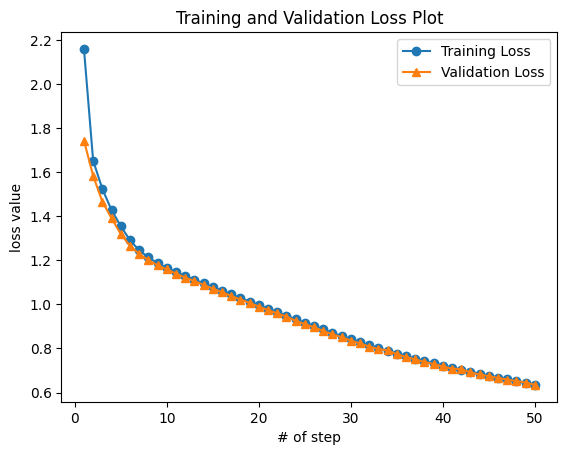

In [160]:
# 繪製每個epoch在 loss 走勢圖

xticks = list( range(1, len(train_losses)+1, 1) )

plt.plot(xticks, train_losses, "-o", label="Training Loss")
plt.plot(xticks, eval_losses, "-^", label="Validation Loss")
plt.xlabel("# of step")
plt.ylabel('loss value')
plt.legend()
plt.title("Training and Validation Loss Plot")

plt.show()

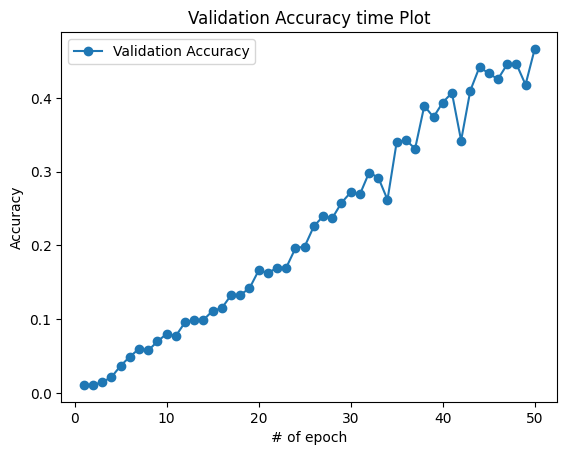

In [161]:
# 繪製每個epoch在validation dataset準確度圖
xticks = list( range(1, len(acc)+1, 1) )

plt.plot(xticks, acc, "-o", label="Validation Accuracy")
plt.xlabel("# of epoch")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Validation Accuracy time Plot")

plt.show()

In [162]:
# 計算測試資料分數

model = torch.load(f"{model_name}_best.mod")
correct = 0

for batch_x, batch_y in test_loader:

    for x in batch_x:
        index = (x==char_to_id["="]).nonzero().item()

        ans = x[index+1:]
        pred = model.generator(list(x[:index+1]))
        hit = True

        if len(ans) == len(pred):
            for a, p in zip(ans, pred):
                if a != p:
                    hit = False
                    break
        else:
            hit = False

        if hit:
            correct += 1


print(f"Test Accuracy {correct/len(test_loader.dataset)*100:.2f}%")

Test Accuracy 46.98%
